In [13]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [14]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint
from holo.__typing import assertIsinstance

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [16]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper1

def cell():
    global handleDatas, train, MoE_models, basicModels
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    MoE_models.paper1 = importlib.reload(MoE_models.paper1)

cell();

In [17]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [ ]:
def cell():
    gatingModel, experts, loss = basicModels.BasicImageClassifModel.get_Cifar_like_32x32x3_moe(
        device=device, nbClasses=datasHandler.nbClasses, 
        gatingModelConfig='small', nbExperts=6, expertsModelConfig="small")
    moeModel = MoE_models.paper1.MOE_Model(
        experts=experts, gatingModel=gatingModel, isClassif=True, myLoss=False)
    return moeModel, loss
model, baseLoss = cell(); del cell
hist = train.HistoryClassification()
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
print(f"nbParams gating: {basicModels.countTotalParameters(model.gatingModel.parameters()):_d}")
print(f"""nbParams experts: [{', '.join([f"{basicModels.countTotalParameters(expert.parameters()):_d}" for expert in model.experts])}]""")

trainer = train.TrainerClassif_MoE1(model=model, optimizer=optim, criterion=baseLoss, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
assert _[1].shape == (1, datasHandler.nbClasses, model.nbExperts), f"{_[1].shape = }"
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

nbParams total: 223_458
nbParams gating: 29_286
nbParams experts: [32_362, 32_362, 32_362, 32_362, 32_362, 32_362]


In [19]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=30);

Epoch 1, train: (loss: 0.8021, accuracy: 44.07%), test: (loss: 0.6945, accuracy: 53.11%), lr: 1.0000e-03
Epoch 2, train: (loss: 0.6348, accuracy: 56.75%), test: (loss: 0.7037, accuracy: 53.47%), lr: 1.0000e-03
Epoch 3, train: (loss: 0.5629, accuracy: 62.10%), test: (loss: 0.6841, accuracy: 55.83%), lr: 1.0000e-03
Epoch 4, train: (loss: 0.5135, accuracy: 65.44%), test: (loss: 0.5663, accuracy: 62.98%), lr: 1.0000e-03
Epoch 5, train: (loss: 0.48, accuracy: 67.87%), test: (loss: 0.5032, accuracy: 66.47%), lr: 1.0000e-03
Epoch 6, train: (loss: 0.4504, accuracy: 69.70%), test: (loss: 0.5067, accuracy: 66.01%), lr: 1.0000e-03
Epoch 7, train: (loss: 0.4267, accuracy: 71.59%), test: (loss: 0.5331, accuracy: 64.89%), lr: 1.0000e-03
Epoch 8, train: (loss: 0.4017, accuracy: 73.06%), test: (loss: 0.5012, accuracy: 66.77%), lr: 1.0000e-03
Epoch 9, train: (loss: 0.3771, accuracy: 74.87%), test: (loss: 0.5018, accuracy: 67.03%), lr: 1.0000e-03
Epoch 10, train: (loss: 0.361, accuracy: 75.73%), test: (

In [24]:
def cell():
    
    htest = assertIsinstance(train.Moe1ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
    print(f"-> RESULT")
    print(f"mean: {htest.meanExpertsGate().round(3)} (std: {htest.meanExpertsGate().std(axis=0).round(3)})")
    print(f"std: {htest.meanPredClassesExpertsGate().std(axis=0).round(3)} (mean: {htest.meanPredClassesExpertsGate().std(axis=0).mean().round(3)})")
    print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
    print("\n")
    
    rnd = 2
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        for h in trainer.history:
            htest = assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain = assertIsinstance(train.Moe1ExpertsInsigths, h.train.moeExpertsInsigths)
            print(" ->", h.epochID)
            #print(htest.nbPred.round(rnd))
            #print(htest.nbTruth.round(rnd))
            print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
            print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
            print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
            print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
            print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
            #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
            #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
            print()
    

cell(); del cell

-> RESULT
mean: [0.237 0.142 0.176 0.201 0.086 0.159] (std: 0.047)
std: [0.154 0.11  0.188 0.245 0.093 0.083] (mean: 0.146)
perClassPred: 
[[0.05 0.08 0.24 0.42 0.24 0.38 0.21 0.53 0.05 0.18]
 [0.05 0.34 0.15 0.18 0.03 0.33 0.02 0.1  0.08 0.11]
 [0.38 0.34 0.05 0.02 0.03 0.   0.   0.06 0.53 0.32]
 [0.02 0.03 0.3  0.07 0.65 0.12 0.68 0.18 0.   0.01]
 [0.31 0.06 0.08 0.06 0.01 0.06 0.   0.01 0.22 0.04]
 [0.19 0.15 0.18 0.25 0.05 0.1  0.09 0.12 0.12 0.34]]


 -> 1
delta (nbPred-nbTruth) per class[test]:
 [ -94  327 -222  470 -169  -41  -21  220 -150 -320]
mean experts use[train]: [0.16 0.16 0.19 0.13 0.15 0.21]
mean experts use[test]: [0.23 0.11 0.18 0.14 0.15 0.18]
mean experts use per class predicted [test]:
[[0.02 0.1  0.35 0.38 0.43 0.23 0.37 0.31 0.04 0.04]
 [0.03 0.19 0.07 0.15 0.08 0.2  0.06 0.13 0.08 0.03]
 [0.33 0.22 0.1  0.03 0.03 0.12 0.01 0.22 0.47 0.43]
 [0.01 0.04 0.28 0.2  0.38 0.13 0.31 0.08 0.01 0.  ]
 [0.38 0.19 0.09 0.06 0.03 0.2  0.03 0.13 0.24 0.19]
 [0.23 0.26 0.11 0

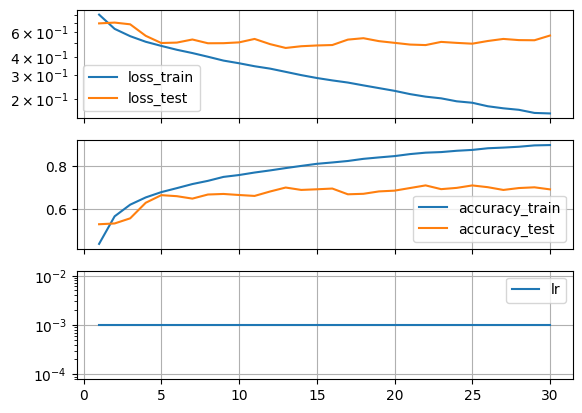

In [21]:
trainer.history.plot();

In [22]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
cell(); del cell

Epoch 1, train: (loss: 0.8021, accuracy: 44.07%), test: (loss: 0.6945, accuracy: 53.11%), lr: 1.0000e-03
        Epoch 2, train: (loss: 0.6348, accuracy: 56.75%), test: (loss: 0.7037, accuracy: 53.47%), lr: 1.0000e-03
        Epoch 3, train: (loss: 0.5629, accuracy: 62.10%), test: (loss: 0.6841, accuracy: 55.83%), lr: 1.0000e-03
        Epoch 4, train: (loss: 0.5135, accuracy: 65.44%), test: (loss: 0.5663, accuracy: 62.98%), lr: 1.0000e-03
        Epoch 5, train: (loss: 0.48, accuracy: 67.87%), test: (loss: 0.5032, accuracy: 66.47%), lr: 1.0000e-03
        Epoch 6, train: (loss: 0.4504, accuracy: 69.70%), test: (loss: 0.5067, accuracy: 66.01%), lr: 1.0000e-03
        Epoch 7, train: (loss: 0.4267, accuracy: 71.59%), test: (loss: 0.5331, accuracy: 64.89%), lr: 1.0000e-03
        Epoch 8, train: (loss: 0.4017, accuracy: 73.06%), test: (loss: 0.5012, accuracy: 66.77%), lr: 1.0000e-03
        Epoch 9, train: (loss: 0.3771, accuracy: 74.87%), test: (loss: 0.5018, accuracy: 67.03%), lr: 1.00

In [23]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 916   15   73   31   35   14   14   15   69   40]
 [  40 1001   10   18    9    9   10   12   42  188]
 [  42    9  684   72   67   83   44   30   17    9]
 [  21   12   94  619   87  211  102   59   16   28]
 [  15    6  128   58  729   66   57   65    7    6]
 [  14   13  110  202   65  690   33   94    8   17]
 [  10   16   64   84   54   37  937    5   10   18]
 [  19   12   46   34   79   58   12  886    6   13]
 [  93   31   25   32   12   14   12    8  958   30]
 [  35   86   10   29   13   21    8   26   31  876]]

class: 0, precision:74.96%, hitRate: 76.02%
class: 1, precision:74.76%, hitRate: 83.35%
class: 2, precision:64.71%, hitRate: 54.98%
class: 3, precision:49.56%, hitRate: 52.50%
class: 4, precision:64.12%, hitRate: 63.39%
class: 5, precision:55.38%, hitRate: 57.36%
class: 6, precision:75.87%, hitRate: 76.24%
class: 7, precision:76.05%, hitRate: 73.83%
class: 8, precision:78.85%, hitRate: 82.30%
class: 9, precision:77.18%, hitRate: 71.51%

[
    (0.056965442764578836